In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-03-30 01:36:04--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.114.216, 54.231.192.112, 54.231.164.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.114.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  17.8MB/s    in 0.7s    

2024-03-30 01:36:05 (17.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [8]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [9]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("model_base.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("model_base.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
819/819 [==============================] - 10s 10ms/step - loss: 12.9662 - mae: 2.7810 - val_loss: 11.4684 - val_mae: 2.6704
Epoch 2/30
819/819 [==============================] - 9s 10ms/step - loss: 8.9955 - mae: 2.3656 - val_loss: 11.5441 - val_mae: 2.6787
Epoch 3/30
819/819 [==============================] - 9s 10ms/step - loss: 8.2933 - mae: 2.2708 - val_loss: 10.4489 - val_mae: 2.5412
Epoch 4/30
819/819 [==============================] - 8s 10ms/step - loss: 7.8372 - mae: 2.2097 - val_loss: 10.8274 - val_mae: 2.5890
Epoch 5/30
819/819 [==============================] - 8s 10ms/step - loss: 7.5455 - mae: 2.1688 - val_loss: 10.4990 - val_mae: 2.5517
Epoch 6/30
819/819 [==============================] - 8s 10ms/step - loss: 7.3248 - mae: 2.1368 - val_loss: 12.1448 - val_mae: 2.7637
Epoch 7/30
819/819 [==============================] - 8s 10ms/step - loss: 7.1546 - mae: 2.1126 - val_loss: 11.0018 - val_mae: 2.6125
Epoch 8/30
819/819 [==============================] - 8s 10m

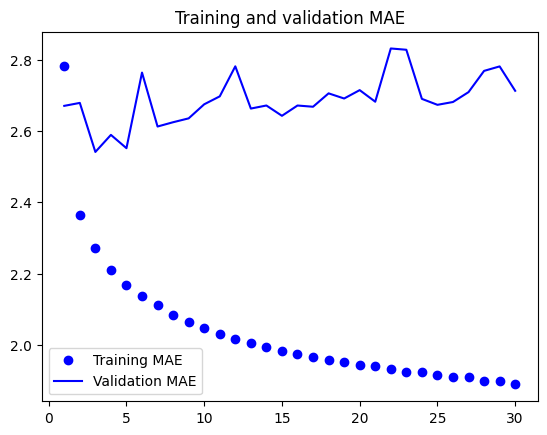

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("model_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("model_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
819/819 [==============================] - 13s 13ms/step - loss: 39.0788 - mae: 4.5556 - val_loss: 12.2861 - val_mae: 2.6793
Epoch 2/30
819/819 [==============================] - 11s 13ms/step - loss: 10.9150 - mae: 2.5578 - val_loss: 9.4576 - val_mae: 2.4050
Epoch 3/30
819/819 [==============================] - 10s 13ms/step - loss: 9.5312 - mae: 2.4051 - val_loss: 9.6998 - val_mae: 2.4484
Epoch 4/30
819/819 [==============================] - 10s 13ms/step - loss: 8.9736 - mae: 2.3375 - val_loss: 9.7147 - val_mae: 2.4395
Epoch 5/30
819/819 [==============================] - 10s 13ms/step - loss: 8.6666 - mae: 2.2951 - val_loss: 9.7842 - val_mae: 2.4401
Epoch 6/30
819/819 [==============================] - 10s 13ms/step - loss: 8.3893 - mae: 2.2577 - val_loss: 10.2687 - val_mae: 2.5031
Epoch 7/30
819/819 [==============================] - 10s 13ms/step - loss: 8.1527 - mae: 2.2247 - val_loss: 9.7135 - val_mae: 2.4281
Epoch 8/30
819/819 [==============================] - 10s 

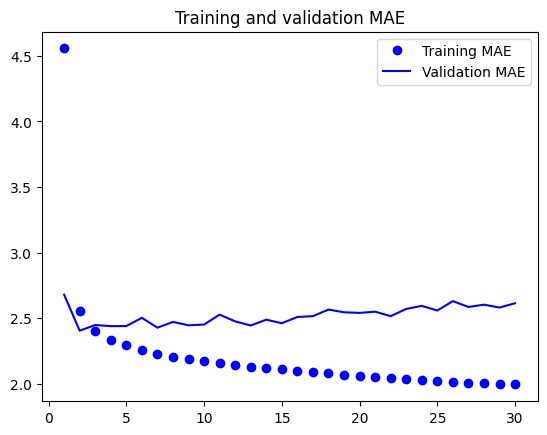

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("model_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("model_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
819/819 [==============================] - 18s 18ms/step - loss: 24.1677 - mae: 3.5835 - val_loss: 9.2371 - val_mae: 2.3563
Epoch 2/30
819/819 [==============================] - 14s 17ms/step - loss: 12.0803 - mae: 2.6981 - val_loss: 9.0649 - val_mae: 2.3383
Epoch 3/30
819/819 [==============================] - 14s 17ms/step - loss: 11.2012 - mae: 2.6023 - val_loss: 8.9780 - val_mae: 2.3335
Epoch 4/30
819/819 [==============================] - 14s 17ms/step - loss: 10.4693 - mae: 2.5189 - val_loss: 8.8901 - val_mae: 2.3156
Epoch 5/30
819/819 [==============================] - 14s 17ms/step - loss: 9.9000 - mae: 2.4472 - val_loss: 9.1739 - val_mae: 2.3485
Epoch 6/30
819/819 [==============================] - 14s 17ms/step - loss: 9.2027 - mae: 2.3600 - val_loss: 9.5370 - val_mae: 2.4008
Epoch 7/30
819/819 [==============================] - 14s 17ms/step - loss: 8.4690 - mae: 2.2636 - val_loss: 9.8493 - val_mae: 2.4490
Epoch 8/30
819/819 [==============================] - 14s 

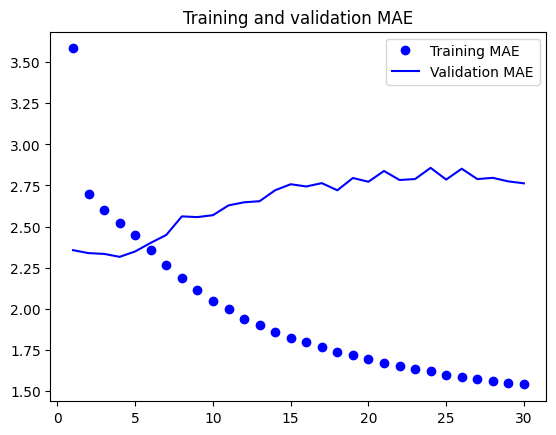

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("model_bidirection.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("model_bidirection.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
819/819 [==============================] - 18s 18ms/step - loss: 29.9469 - mae: 3.9160 - val_loss: 11.3844 - val_mae: 2.6124
Epoch 2/30
819/819 [==============================] - 14s 17ms/step - loss: 9.4530 - mae: 2.4018 - val_loss: 9.7473 - val_mae: 2.4097
Epoch 3/30
819/819 [==============================] - 14s 17ms/step - loss: 8.4197 - mae: 2.2633 - val_loss: 9.7180 - val_mae: 2.4151
Epoch 4/30
819/819 [==============================] - 14s 17ms/step - loss: 7.9253 - mae: 2.1945 - val_loss: 9.8573 - val_mae: 2.4236
Epoch 5/30
819/819 [==============================] - 14s 17ms/step - loss: 7.5916 - mae: 2.1468 - val_loss: 10.0300 - val_mae: 2.4571
Epoch 6/30
819/819 [==============================] - 14s 17ms/step - loss: 7.3098 - mae: 2.1058 - val_loss: 10.4964 - val_mae: 2.5140
Epoch 7/30
819/819 [==============================] - 14s 17ms/step - loss: 7.0836 - mae: 2.0733 - val_loss: 10.6823 - val_mae: 2.5298
Epoch 8/30
819/819 [==============================] - 14s

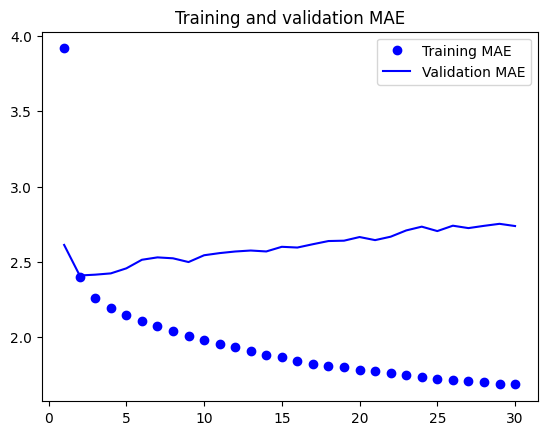

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
x = layers.Dropout(0.7)(x)
x = layers.Bidirectional(layers.LSTM(16))(inputs)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("model_bidirection_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("model_bidirection_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
819/819 [==============================] - 18s 18ms/step - loss: 35.3108 - mae: 4.4472 - val_loss: 12.0394 - val_mae: 2.6910
Epoch 2/30
819/819 [==============================] - 14s 17ms/step - loss: 20.5338 - mae: 3.4913 - val_loss: 11.2082 - val_mae: 2.6056
Epoch 3/30
819/819 [==============================] - 14s 17ms/step - loss: 19.1397 - mae: 3.3668 - val_loss: 10.4149 - val_mae: 2.5143
Epoch 4/30
819/819 [==============================] - 14s 17ms/step - loss: 18.1624 - mae: 3.2799 - val_loss: 10.5712 - val_mae: 2.5362
Epoch 5/30
819/819 [==============================] - 14s 17ms/step - loss: 17.4613 - mae: 3.2117 - val_loss: 10.6405 - val_mae: 2.5461
Epoch 6/30
819/819 [==============================] - 14s 17ms/step - loss: 16.8864 - mae: 3.1580 - val_loss: 10.6616 - val_mae: 2.5505
Epoch 7/30
819/819 [==============================] - 14s 17ms/step - loss: 16.2952 - mae: 3.1024 - val_loss: 10.5659 - val_mae: 2.5328
Epoch 8/30
819/819 [============================

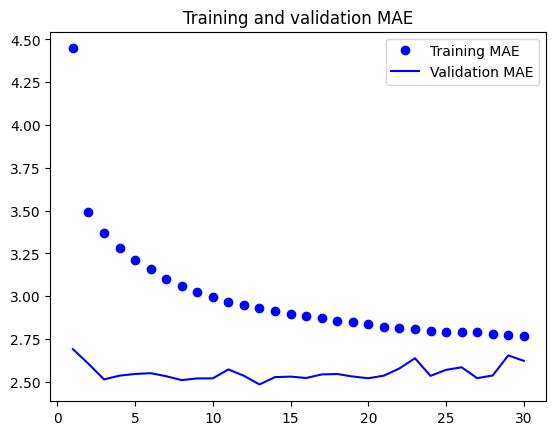

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("model_stacked_gru_dropout_twice.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("model_stacked_gru_dropout_twice.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
819/819 [==============================] - 18s 18ms/step - loss: 40.1573 - mae: 4.7637 - val_loss: 11.8914 - val_mae: 2.6902
Epoch 2/30
819/819 [==============================] - 14s 17ms/step - loss: 31.6859 - mae: 4.2180 - val_loss: 10.7194 - val_mae: 2.5617
Epoch 3/30
819/819 [==============================] - 14s 17ms/step - loss: 28.9836 - mae: 4.0415 - val_loss: 12.4259 - val_mae: 2.7548
Epoch 4/30
819/819 [==============================] - 14s 17ms/step - loss: 26.9221 - mae: 3.8998 - val_loss: 12.1508 - val_mae: 2.7291
Epoch 5/30
819/819 [==============================] - 14s 17ms/step - loss: 25.1904 - mae: 3.7827 - val_loss: 9.8790 - val_mae: 2.4488
Epoch 6/30
819/819 [==============================] - 14s 17ms/step - loss: 23.7992 - mae: 3.6674 - val_loss: 10.9458 - val_mae: 2.5555
Epoch 7/30
819/819 [==============================] - 14s 17ms/step - loss: 22.5675 - mae: 3.5805 - val_loss: 12.8150 - val_mae: 2.8089
Epoch 8/30
819/819 [=============================

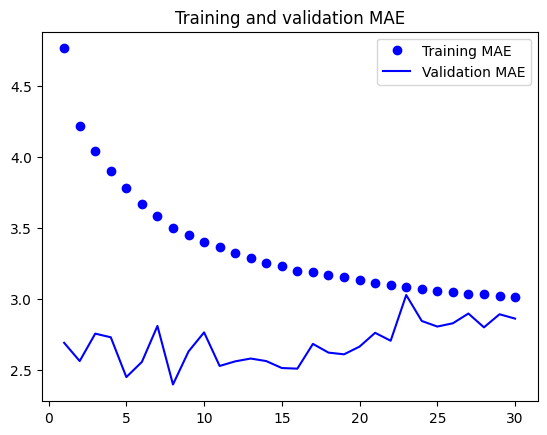

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()